In [ ]:
# Load dataset "compilado_delitos_2022.xlsx" with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Read the data, all strings
df_copy = pd.read_excel('compilado_delitos_2022.xlsx', dtype=str)

In [ ]:
df = df_copy.copy()
#Print dimensions of the dataset
print(df.shape)# Print columns of the dataset
print(df.columns)
# Print the first 5 rows of the data
# df.head()

In [ ]:
''' Save columns and drop the ones that are not needed
       ['fecha_creacion', 'hora_creacion',
       'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
       'sector_inicio', 'latitud', 'longitud']
'''

# Remove YYYY-MM-DD in field hora_creacion
df['hora_creacion'] = df['hora_creacion'].str[11:13]+':00'
# Remove rows with date 2021-12-31
df = df[df.fecha_creacion != '2021-12-31']
df = df[df.fecha_creacion != '2023-01-01']
# Remove YYYY of field fecha_creacion
df['fecha_creacion'] = df['fecha_creacion'].str[5:]
# Map dia_semana from name to int-name
df['dia_semana'] = df['dia_semana'].replace({'Lunes':'1-Lunes', 'Martes':'2-Martes', 'Miércoles':'3-Miércoles', 'Jueves':'4-Jueves', 'Viernes':'5-Viernes', 'Sábado':'6-Sábado', 'Domingo':'7-Domingo'})
# Map mes_creacion from name to int-name
df['mes_creacion'] = df['fecha_creacion'].str[:2].replace({'01':'01-Enero', '02':'02-Febrero', '03':'03-Marzo', '04':'04-Abril', '05':'05-Mayo', '06':'06-Junio', '07':'07-Julio', '08':'08-Agosto', '09':'09-Septiembre', '10':'10-Octubre', '11':'11-Noviembre', '12':'12-Diciembre'})
# Map dia-mes_creacion from name to int
df['dia_creacion'] = df['fecha_creacion'].str[3:]
# Get de week number of the year
df['semana_creacion'] = pd.to_datetime(df['fecha_creacion'], format='%m-%d').dt.week


columns = ['fecha_creacion', 'hora_creacion', 'mes_creacion', 'dia_creacion', 'semana_creacion',
        'dia_semana', 'incidente_c4', 'colonia', 'delegacion_inicio',
        'sector_inicio', 'latitud', 'longitud']

df = df[columns]



# Print the first 5 rows of the data
df.head()

In [ ]:
# Separar los datos por delitos
df_delitos = df.groupby('incidente_c4')
# df_delitos.head()

In [38]:
# 'Estadisticas trimestrales' en ingles: 'Trimestral statistics'
def statistic_frequency(df_main:pd.DataFrame, conditionals:list[pd.Series], groupby:str, titles:list[str], dir:str, num_high:int=5, num_low:int=5):
	from matplotlib.backends.backend_pdf import PdfPages
	import os

	if not os.path.exists(dir):
		os.makedirs(dir)

	with PdfPages(dir + '/'+ dir +'.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, axes = plt.subplots(nrows=1, ncols=len(conditionals), figsize=(5*len(conditionals), 5))
			# check if axes is a list or a single axis
			if not isinstance(axes, np.ndarray):
				axes = [axes]

			df_delito_pts = [delito_df[conditional] for conditional in conditionals]
			
			
			for df_section,title,axe in zip(df_delito_pts, titles, axes):
				delito_df_pt = df_section.groupby(groupby).count()['incidente_c4']
		
				delito_df_pt.plot(ax=axe, color='black', alpha=0.25)
				axe.set_title(title)
				axe.set_xticklabels(axe.get_xticklabels(), rotation=90)

				# Add scatter points with text labels to 5th hights days
				delito_df_pt1_sorted = delito_df_pt.sort_values(ascending=False)
				for i, (x, y) in enumerate(zip(delito_df_pt1_sorted.index, delito_df_pt1_sorted.values)):
					if i < num_low or i+num_high >= len(delito_df_pt1_sorted):
						x_pos = delito_df_pt.index.get_loc(x)
						axe.scatter(x_pos, y, s=10,  color='red' if i<num_low else 'green')
						axe.text(x_pos, y, str(f"{x} [{y}]"), fontsize=8, color='red' if i<num_low else 'green', rotation=90,  horizontalalignment='right', verticalalignment='top')

			#Get Max scale of all axes using get_ylim()
			y_max = max([ax.get_ylim()[1] for ax in axes])
			#Set all axes to the same scale
			for ax in axes:
				ax.set_ylim(0, y_max)


			plt.suptitle(delito)
			plt.savefig(f"{dir}/{delito}.png")
			pdf.savefig()
			plt.show()
		plt.close()

def statistic_heatmap(df_main:pd.DataFrame, index, columns, title, dir:str):
	import os
	import seaborn as sns
	import matplotlib.pyplot as plt
	from matplotlib.backends.backend_pdf import PdfPages

	if not os.path.exists(dir):
		os.makedirs(dir)


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			# Create a pivot table with the count of incidents by day and hour
			delito_df_pt = delito_df.pivot_table(index=index, columns=columns, values='incidente_c4', aggfunc='count', fill_value=0)
			# Plot the heatmap
			fig, ax = plt.subplots()
			sns.heatmap(delito_df_pt, cmap='Spectral_r', annot=True, ax=ax, fmt='d')
			# plt.tick_params(axis='x', labelrotation=90, labeltop=True, labelbottom=False, labelsize=20)
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

def statistic_geomap(df_main:pd.DataFrame, groupby:str, title:str, dir:str, USE_SECTORS:bool=True):
	import os
	import geopandas as gpd
	from shapely.geometry import Point
	from matplotlib.backends.backend_pdf import PdfPages
	import matplotlib.pyplot as plt
	import seaborn as sns

	if not os.path.exists(dir):
		os.makedirs(dir)

	if USE_SECTORS:
		mxcity = gpd.read_file('mapa_mexico_sectores/')\
			.set_index('TERRITORIA')\
			.to_crs(epsg=4326)
	else:
		# Obtain the map of Mexico
		mx = gpd.read_file('mapa_mexico/')\
				.set_index('CLAVE')\
				.to_crs(epsg=4326)
		# obtain the map of Mexico City with the geometry of the city
		mxcity = mx.query('CVE_EDO==\"09\"')

	# leer archivo xlsx de camaras in sheet 'base'
	df_cameras = pd.read_excel('BASE_24ENE023.xlsx', sheet_name='BASE')
	# ob
	df_cameras = df_cameras[['CYGW', 'CXGW']]
	df_cameras = df_cameras.dropna()

	# Coordinate reference system : WGS84
	crs = {'init': 'epsg:4326'}


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		# Plot the cameras
		gdf_cameras = gpd.GeoDataFrame(
			df_cameras,
			crs=crs,
			geometry=gpd.points_from_xy(df_cameras.CXGW, df_cameras.CYGW)
		)
		gdf_cameras.plot(ax=ax, markersize=2, color='blue', alpha=0.1)

		plt.suptitle('Camaras')
		pdf.savefig()
		plt.savefig(f"{dir}/{delito}.png")
		plt.show()


		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, ax = plt.subplots(figsize=(10, 10))

			mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
			#mxcity.plot(ax=ax, color='white', edgecolor='black')

			# Create a GeoDataFrame from the DataFrame
			gdf = gpd.GeoDataFrame(
				delito_df, 
				crs=crs,
				geometry=gpd.points_from_xy(delito_df.longitud, delito_df.latitud)
			)

			# Plot the incidents
			gdf.plot(ax=ax, markersize=2, color='#26A337', alpha=0.075)

			# Add a title
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

def statistic_heatgeomap(df_main:pd.DataFrame, index, columns, title, dir:str, USE_SECTORS:bool=True):
	import os
	import geopandas as gpd
	from shapely.geometry import Point
	from matplotlib.backends.backend_pdf import PdfPages
	import matplotlib.pyplot as plt
	import seaborn as sns

	if not os.path.exists(dir):
		os.makedirs(dir)

	if USE_SECTORS:
		mxcity = gpd.read_file('mapa_mexico_sectores/')\
			.set_index('TERRITORIA')\
			.to_crs(epsg=4326)
	else:
		# Obtain the map of Mexico
		mx = gpd.read_file('mapa_mexico/')\
				.set_index('CLAVE')\
				.to_crs(epsg=4326)
		# obtain the map of Mexico City with the geometry of the city
		mxcity = mx.query('CVE_EDO==\"09\"')

	# leer archivo csv camaras_sectoractual.csv
	df_cameras = pd.read_csv('CAMARAS_SECTORACTUAL.csv', sep=',')
	# ob
	df_cameras = df_cameras[['CYGW', 'CXGW']]
	df_cameras = df_cameras.dropna()

	# Coordinate reference system : WGS84
	crs = {'init': 'epsg:4326'}


	with PdfPages(f'{dir}/{dir}.pdf') as pdf:
		df_main_by_delitos = df_main.groupby('incidente_c4')
		for delito, delito_df in df_main_by_delitos:
			fig, ax = plt.subplots(figsize=(10, 10))

			mxcity.boundary.plot(ax=ax, color='black', linewidth=1.5)
			#mxcity.plot(ax=ax, color='white', edgecolor='black')

			# Create heatmap with dataframe in mexico city
			sns.heatmap(
				delito_df.pivot_table(index=index, columns=columns, aggfunc='size', fill_value=0),
				cmap='YlGnBu',
				ax=ax,
				linewidths=0.1,
				linecolor='white',
				annot=True,
				annot_kws={"size": 8},
				cbar=False
			)

			# Add a title
			ax.set_title(title)
			plt.suptitle(delito)
			pdf.savefig()
			plt.savefig(f"{dir}/{delito}.png")
			plt.show()
		plt.close()

In [ ]:
# Tendencia por hora del dia
statistic_frequency(
	df,
	[df['hora_creacion']>''],
	'hora_creacion',
	['Enero - Diciembre 2022'],
    'tendencia_diaria',
    4,6
)

In [ ]:
# Tendencia por dia de la semana
statistic_frequency(
	df,
	[df['incidente_c4']>''],
	'dia_semana',
	['Enero - Diciembre 2022'],
    'tendencia_semanal',
    2,2
)

In [ ]:
# Tendencia por dia del mes
statistic_frequency(
	df,
	[df['incidente_c4']>''],
	'dia_creacion',
	['Enero - Diciembre 2022'],
    'tendencia_mensual',
    5,5
)

In [ ]:
# Tendencia por mes del año
statistic_frequency(
	df,
	[
		df['fecha_creacion'] < '04-01',
		((df['fecha_creacion'] >= '04-01') & (df['fecha_creacion'] < '07-01')),
		((df['fecha_creacion'] >= '07-01') & (df['fecha_creacion'] < '10-01')),
		(df['fecha_creacion'] >= '10-01')
	], 
	'fecha_creacion', 
	['Enero - Marzo 2022', 'Abril - Junio 2022', 'Julio - Septiembre 2022', 'Octubre - Diciembre 2022'],
	'tendencia_trimestral',
	5, 5
)

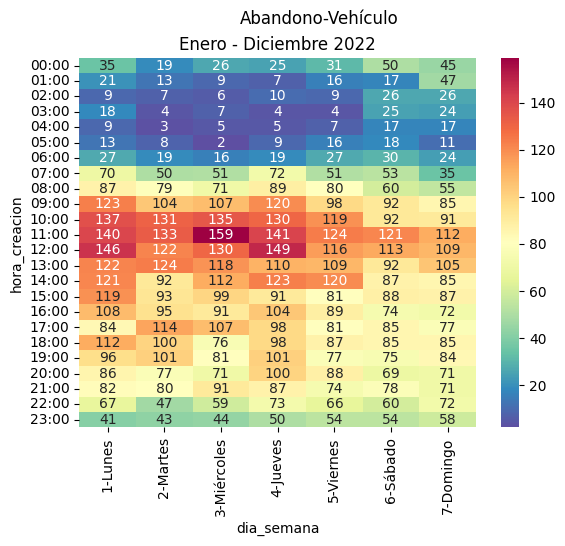

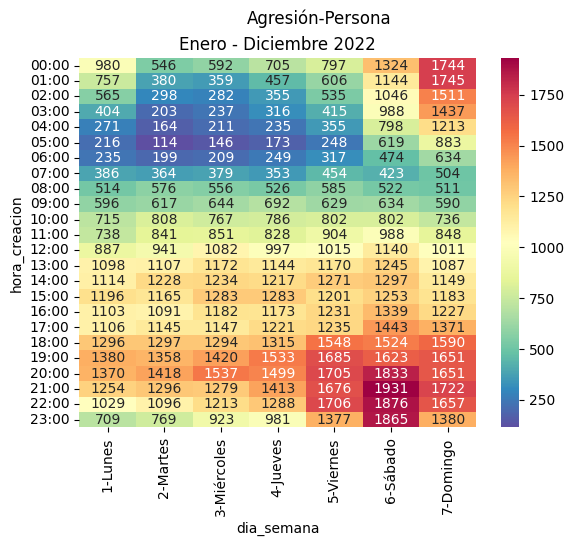

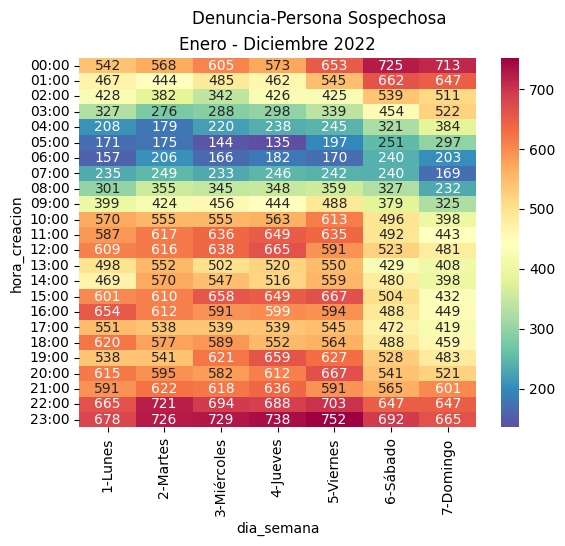

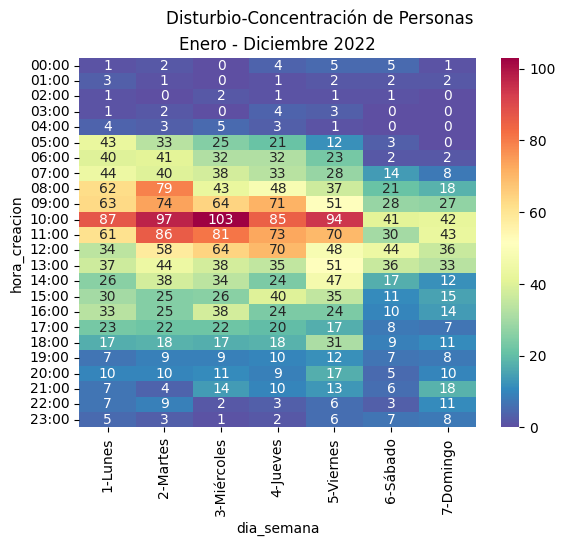

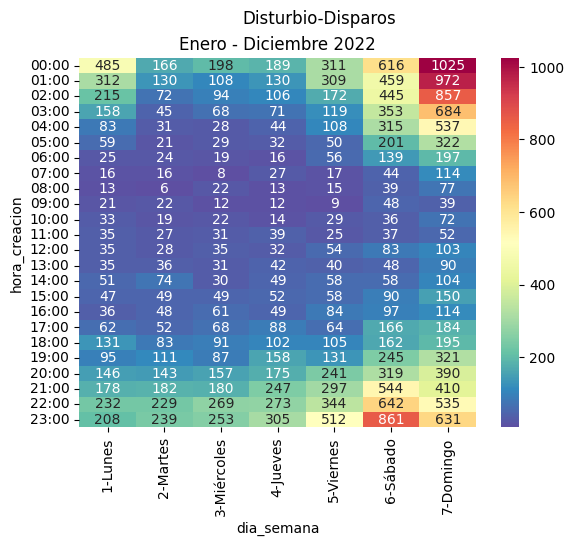

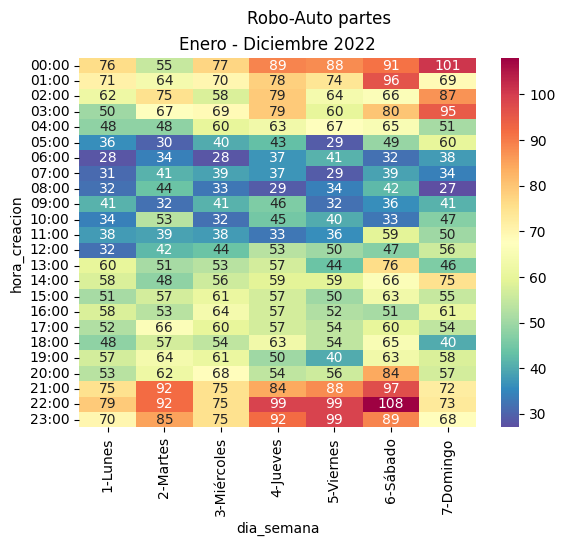

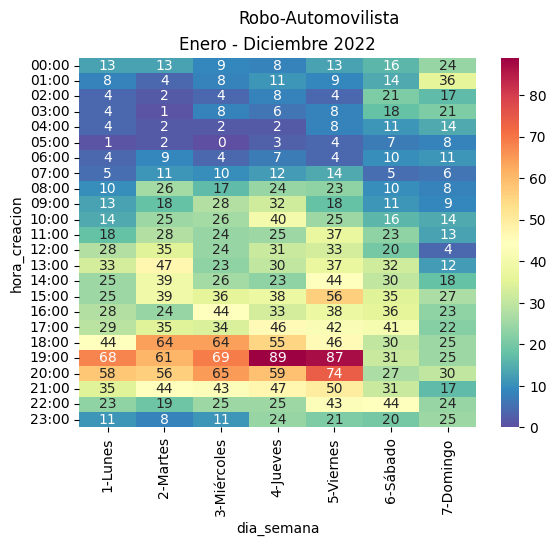

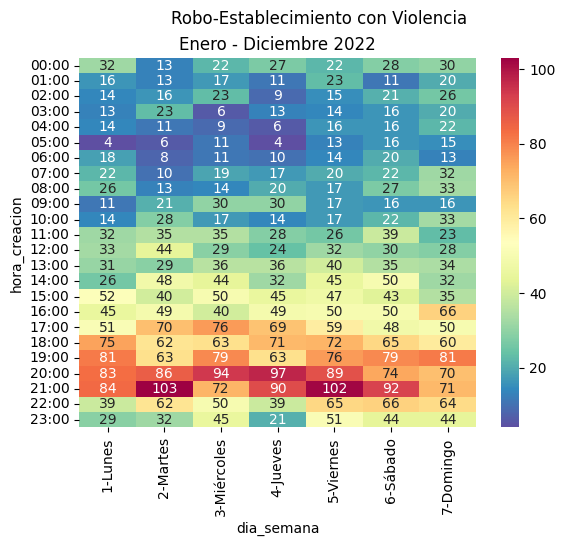

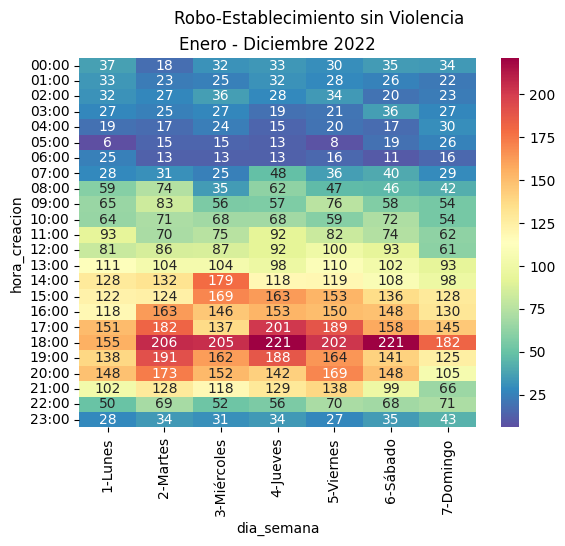

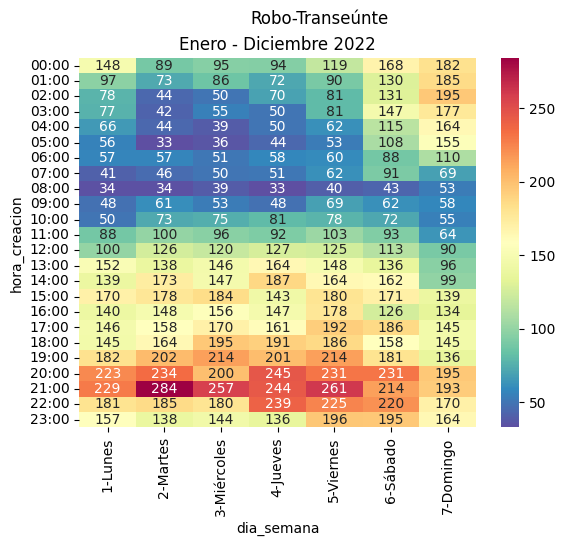

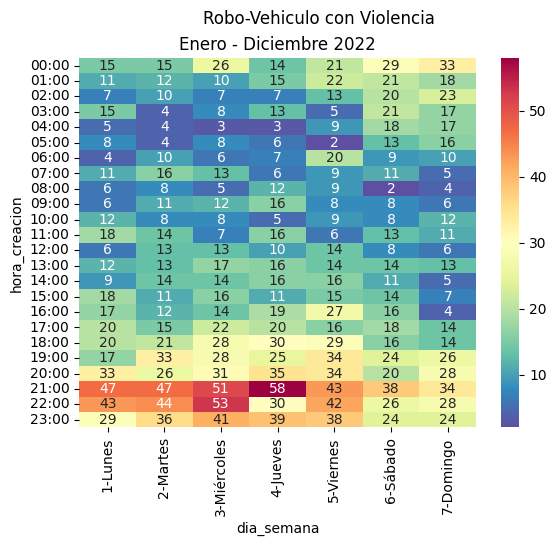

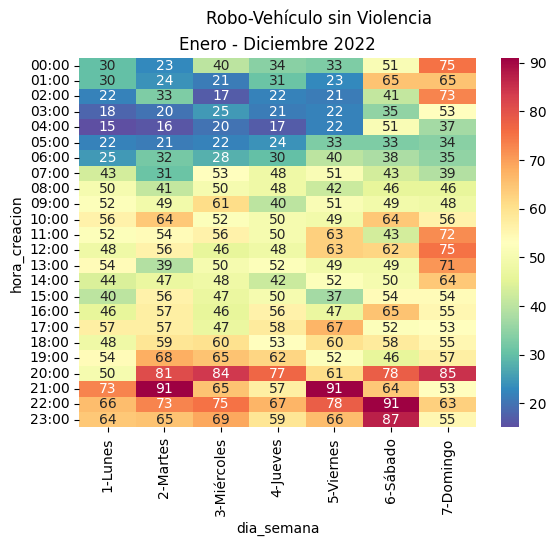

In [39]:
statistic_heatmap(
    df,
    'hora_creacion',
    'dia_semana',
    'Enero - Diciembre 2022',
    'heatmap_dia_hora',
)

In [ ]:
statistic_heatmap(
    df,
    'dia_creacion',
    'mes_creacion',
    'Enero - Diciembre 2022',
    'heatmap_mes_dia',
)

In [ ]:
# Heatmap for each delegacion_inicio
# for delegacion in df['delegacion_inicio'].unique():
#     statistic_heatmap(
#         df[df['delegacion_inicio']==delegacion],
#         'hora_creacion',
#         'dia_semana',
#         f'{delegacion} | Enero - Diciembre 2022',
#         f'heatmap_dia_hora-{delegacion}',
#     )

In [ ]:
#statistic_geomap(
#    df, 
#    'incidente_c4', 
#    'Enero - Diciembre 2022', 
#    'geomap_anual', 
#    True
#)

In [ ]:
#statistic_heatgeomap(
#    df, 
#    'latitud', 'longitud',
#    'Enero - Diciembre 2022', 
#    'geomap_heat_anual', 
#    False
#)

In [62]:
import time
import folium
from folium.plugins import HeatMap
import io
from PIL import Image

# Create a heatmap for gruops of delitos
import os
if not os.path.exists('maps'):
	os.makedirs('maps')

for delito in df['incidente_c4'].unique():
    m = folium.Map(
        location=[19.399276250942087, -99.12435477661893],
        zoom_start=11,
        tiles='stamentoner'#'cartodbpositron'
    )
    HeatMap(
        data=df[df['incidente_c4']==delito][['latitud', 'longitud']].values.tolist(),
        radius=12.5,
        max_zoom=13
    ).add_to(m)
    # open or create the folder with the name 'maps' to save the maps in html format 
    
    # save the map to html
    m.save(f'maps/{delito}.html')
	# wait for the map to be saved

!node screenshot_maps.js


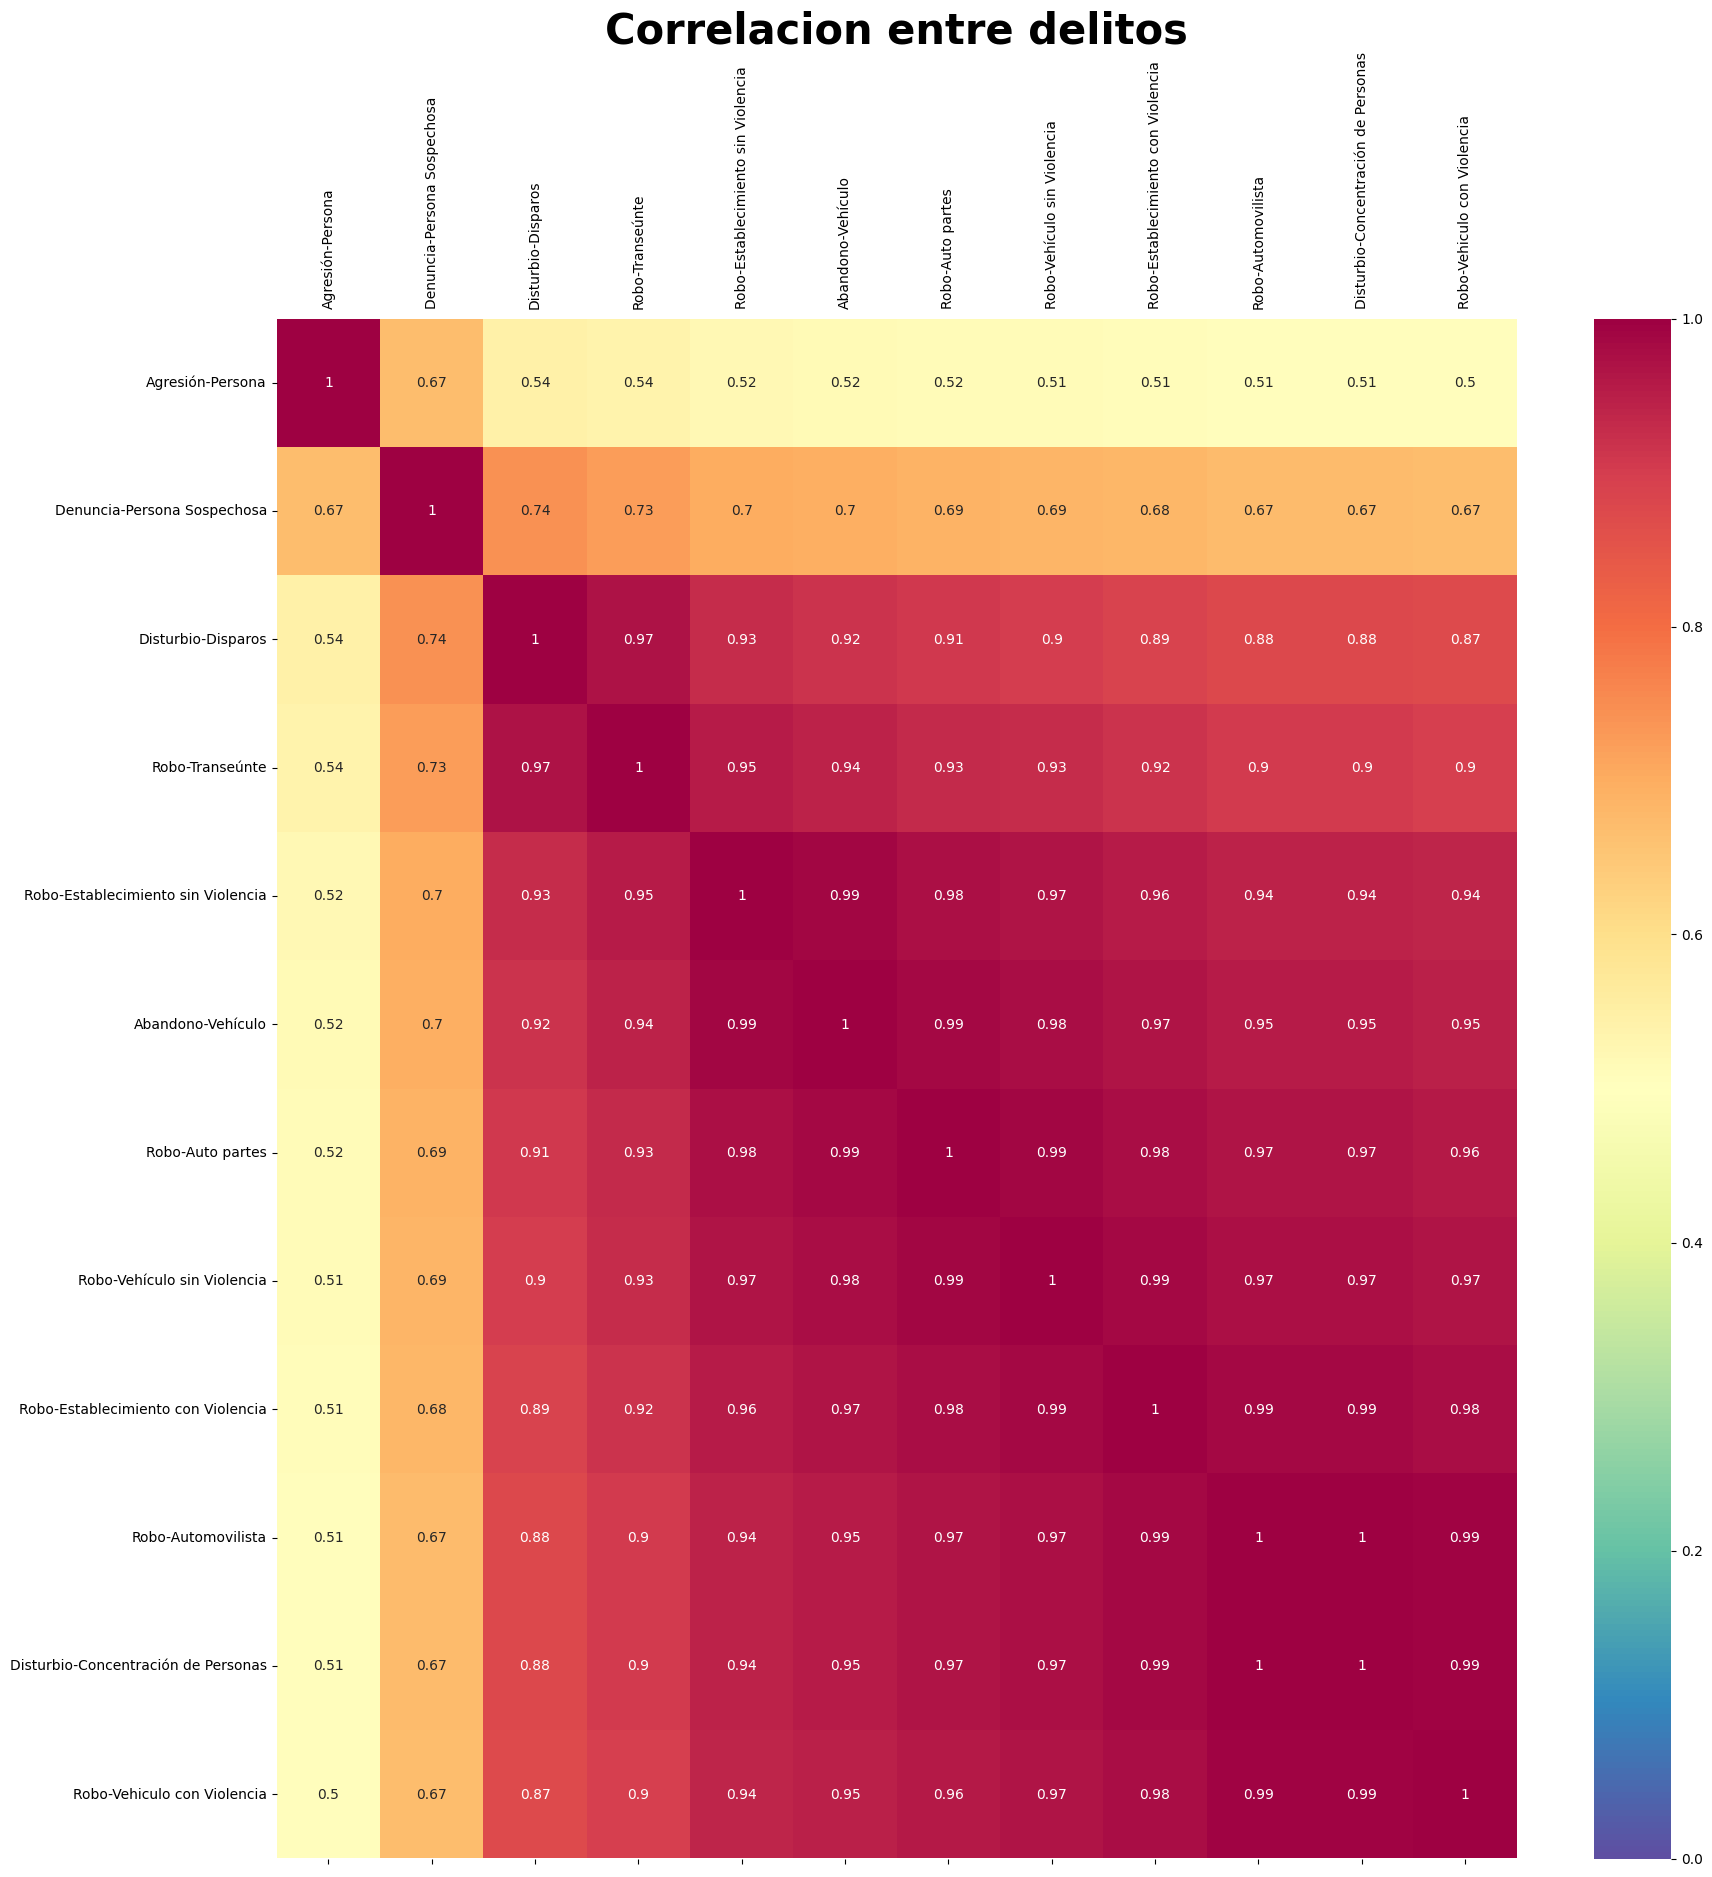

In [53]:
# Guardar la salida del for en una matriz
import seaborn as sns
import matplotlib.pyplot as plt
# normalizar los delitos todos sumando 1
# delitos_count_norm=df['incidente_c4'].value_counts()/(df['incidente_c4'].value_counts().sum()+1)
# normalizar los delitos por el maximo
delitos_count_norm=df['incidente_c4'].value_counts()/max(df['incidente_c4'].value_counts())
matriz=[]
for delito in delitos_count_norm:
    fila=[]
    for delito2 in delitos_count_norm:
        fila.append(1/(abs(delito-delito2)+1))
    matriz.append(fila)

# graficar la matriz en un heatmap con los indices de los delitos
plt.figure(figsize=(20,20))
plt.title('Correlacion entre delitos', fontsize=30, fontweight='bold')
sns.heatmap(matriz, xticklabels=delitos_count_norm.index, yticklabels=delitos_count_norm.index, annot=True, cmap='Spectral_r', vmin=0, vmax=1)
plt.tick_params(axis='x', labelrotation=90, labeltop=True, labelbottom=False)
plt.savefig('correlacion_delitos.png')
plt.show()